# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [ ]:
data_dir = '/data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

In [ ]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
# Note: because of a version problem with matplot lib, the following line of code doesn't work in this workspace.
#pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

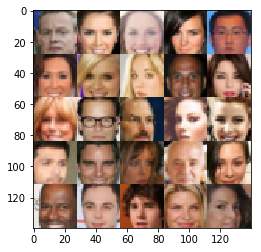

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.3.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name = 'input_real')
    input_z = tf.placeholder(tf.float32, (None, z_dim), name = 'input_z')
    learning_rate = tf.placeholder(tf.float32, (), name = 'learning_rate')

    return input_real, input_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def lrelu(x, alpha):
    return tf.maximum(x * alpha, x)

In [23]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    
    alpha = 0.1
    
    with tf.variable_scope('discriminator', reuse = reuse):
        # Input is 28x28x3
        x1 = tf.layers.conv2d(images, 64, 5, strides = 2, padding = 'same',initializer=tf.contrib.layers.xavier_initializer())
        x1 = lrelu(x1, alpha)
        x1 = tf.layers.dropout(x1, 0.8)
        
        # 14x14x64
        x2 = tf.layers.conv2d(x1, 128, 5, strides = 2, padding = 'same')
        x2 = lrelu(x2, alpha)
        x2 = tf.layers.batch_normalization(x2, training = True)
        x2 = tf.layers.dropout(x2, 0.8)
        
        # 7x7x128
        x3 = tf.layers.conv2d(x2, 256, 5, strides = 2, padding = 'same')
        x3 = lrelu(x3, alpha)
        x3 = tf.layers.batch_normalization(x3, training = True)
        x3 = tf.layers.dropout(x3, 0.8)
       
        # 4x4x256
        flatten = tf.reshape(x3, (-1, 4 * 4 * 256))
        logits = tf.layers.dense(flatten, 1)
        out = tf.sigmoid(logits)

    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [24]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    
    alpha = 0.1
    
    with tf.variable_scope('generator', reuse = (not is_train)):
        x1 = tf.layers.dense(z, 7 * 7 * 512)
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        x1 = lrelu(x1, alpha)
        x1 = tf.layers.batch_normalization(x1, training = is_train)
        x1 = tf.layers.dropout(x1, 0.5)
        
        # 7x7x512
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding = 'same')
        x2 = lrelu(x2, alpha)
        x2 = tf.layers.batch_normalization(x2, training = is_train)
        x2 = tf.layers.dropout(x2, 0.5)
        
        # 14x14x256
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides = 2, padding = 'same')
        x3 = lrelu(x3, alpha)
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.layers.dropout(x3, 0.5)
        
        # 28x28x128
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 3, strides = 1, padding = 'same')
        
        out = tf.tanh(logits)
    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [40]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, out_channel_dim)
    d_real_model, d_real_logits = discriminator(input_real)
    d_fake_model, d_fake_logits = discriminator(g_model, reuse = True)

    d_real_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = d_real_logits, labels = tf.ones_like(d_real_model)))
    d_fake_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = d_fake_logits, labels = tf.zeros_like(d_fake_model)))
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = d_fake_logits, labels = tf.ones_like(d_fake_model)))

    d_loss = d_real_loss + d_fake_loss
    
    return d_loss, g_loss

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [41]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # Get discriminator and generator variables
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Run optimizer
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1 = beta1).minimize(d_loss, var_list = d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1 = beta1).minimize(g_loss, var_list = g_vars)

    return d_train_opt, g_train_opt    


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [42]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, is_train=False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [47]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    
    input_real, input_z, learn_rate = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, learn_rate, beta1)
    
    steps = 0
    print_every = 10
    show_every = 100

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1
                #get to between -1 and 1
                batch_images *= 2
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, learn_rate: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z, learn_rate: learning_rate})

                if steps % print_every == 0:
                    # Get the losses and print them out after each 10 steps
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % show_every == 0:
                    #since the matplot lib has issues with greyscale images use do rgb only 
                    if data_image_mode == 'RGB':
                        show_generator_output(sess, batch_size, input_z, data_shape[3], data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

In [50]:
batch_size = 32
z_dim = 100
learning_rate = 0.0005
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

Epoch 1/2... Discriminator Loss: 0.3833... Generator Loss: 4.7109
Epoch 1/2... Discriminator Loss: 0.1516... Generator Loss: 2.9338
Epoch 1/2... Discriminator Loss: 0.8344... Generator Loss: 6.8517
Epoch 1/2... Discriminator Loss: 0.5941... Generator Loss: 2.4672
Epoch 1/2... Discriminator Loss: 0.2296... Generator Loss: 5.1875
Epoch 1/2... Discriminator Loss: 0.7379... Generator Loss: 1.8877
Epoch 1/2... Discriminator Loss: 1.6782... Generator Loss: 2.1293
Epoch 1/2... Discriminator Loss: 1.7463... Generator Loss: 0.4014
Epoch 1/2... Discriminator Loss: 1.1500... Generator Loss: 1.1301
Epoch 1/2... Discriminator Loss: 1.7879... Generator Loss: 0.4078
Epoch 1/2... Discriminator Loss: 1.7455... Generator Loss: 1.2382
Epoch 1/2... Discriminator Loss: 1.7536... Generator Loss: 0.2523
Epoch 1/2... Discriminator Loss: 1.4228... Generator Loss: 0.7152
Epoch 1/2... Discriminator Loss: 1.0888... Generator Loss: 1.9777
Epoch 1/2... Discriminator Loss: 1.6231... Generator Loss: 0.3375
Epoch 1/2.

Epoch 1/2... Discriminator Loss: 1.7793... Generator Loss: 0.3367
Epoch 1/2... Discriminator Loss: 1.0108... Generator Loss: 2.6296
Epoch 1/2... Discriminator Loss: 1.1650... Generator Loss: 0.7242
Epoch 1/2... Discriminator Loss: 1.1326... Generator Loss: 0.6630
Epoch 1/2... Discriminator Loss: 1.2276... Generator Loss: 2.7260
Epoch 1/2... Discriminator Loss: 0.9899... Generator Loss: 2.1410
Epoch 1/2... Discriminator Loss: 1.8463... Generator Loss: 0.2522
Epoch 1/2... Discriminator Loss: 1.4688... Generator Loss: 0.3714
Epoch 1/2... Discriminator Loss: 0.8970... Generator Loss: 0.9101
Epoch 1/2... Discriminator Loss: 0.9882... Generator Loss: 1.7575
Epoch 1/2... Discriminator Loss: 1.4098... Generator Loss: 0.4460
Epoch 1/2... Discriminator Loss: 1.6934... Generator Loss: 0.3201
Epoch 1/2... Discriminator Loss: 0.8117... Generator Loss: 2.3628
Epoch 1/2... Discriminator Loss: 0.9255... Generator Loss: 0.7092
Epoch 1/2... Discriminator Loss: 3.1120... Generator Loss: 0.0999
Epoch 1/2.

Epoch 2/2... Discriminator Loss: 0.4730... Generator Loss: 1.4578
Epoch 2/2... Discriminator Loss: 1.9180... Generator Loss: 0.2603
Epoch 2/2... Discriminator Loss: 0.6332... Generator Loss: 0.9402
Epoch 2/2... Discriminator Loss: 3.2147... Generator Loss: 0.1139
Epoch 2/2... Discriminator Loss: 1.7395... Generator Loss: 0.3490
Epoch 2/2... Discriminator Loss: 1.8141... Generator Loss: 0.2690
Epoch 2/2... Discriminator Loss: 0.3466... Generator Loss: 1.6771
Epoch 2/2... Discriminator Loss: 0.8311... Generator Loss: 0.8813
Epoch 2/2... Discriminator Loss: 0.9473... Generator Loss: 1.2529
Epoch 2/2... Discriminator Loss: 1.1386... Generator Loss: 0.6681
Epoch 2/2... Discriminator Loss: 1.3860... Generator Loss: 0.4349
Epoch 2/2... Discriminator Loss: 2.7358... Generator Loss: 0.1015
Epoch 2/2... Discriminator Loss: 2.9767... Generator Loss: 0.0748
Epoch 2/2... Discriminator Loss: 2.5946... Generator Loss: 0.1218
Epoch 2/2... Discriminator Loss: 4.1172... Generator Loss: 0.0754
Epoch 2/2.

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 5.2207... Generator Loss: 0.0503
Epoch 1/1... Discriminator Loss: 0.4381... Generator Loss: 3.3970
Epoch 1/1... Discriminator Loss: 0.1985... Generator Loss: 4.6024
Epoch 1/1... Discriminator Loss: 0.8098... Generator Loss: 1.4651
Epoch 1/1... Discriminator Loss: 0.1791... Generator Loss: 3.8581
Epoch 1/1... Discriminator Loss: 5.4488... Generator Loss: 0.0311
Epoch 1/1... Discriminator Loss: 3.6659... Generator Loss: 0.2018
Epoch 1/1... Discriminator Loss: 2.3086... Generator Loss: 0.4240
Epoch 1/1... Discriminator Loss: 2.4551... Generator Loss: 0.3003
Epoch 1/1... Discriminator Loss: 7.3564... Generator Loss: 11.5123


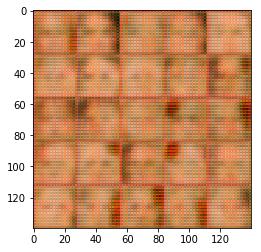

Epoch 1/1... Discriminator Loss: 0.9320... Generator Loss: 1.2291
Epoch 1/1... Discriminator Loss: 2.3847... Generator Loss: 0.1677
Epoch 1/1... Discriminator Loss: 2.5219... Generator Loss: 4.9011
Epoch 1/1... Discriminator Loss: 1.4664... Generator Loss: 0.6609
Epoch 1/1... Discriminator Loss: 1.2607... Generator Loss: 2.1154
Epoch 1/1... Discriminator Loss: 0.8549... Generator Loss: 1.5716
Epoch 1/1... Discriminator Loss: 1.6940... Generator Loss: 0.5738
Epoch 1/1... Discriminator Loss: 0.9876... Generator Loss: 0.7799
Epoch 1/1... Discriminator Loss: 1.3595... Generator Loss: 0.5163
Epoch 1/1... Discriminator Loss: 1.2771... Generator Loss: 1.7482


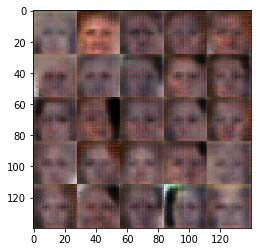

Epoch 1/1... Discriminator Loss: 2.9582... Generator Loss: 0.1125
Epoch 1/1... Discriminator Loss: 1.3214... Generator Loss: 0.7266
Epoch 1/1... Discriminator Loss: 1.5224... Generator Loss: 1.0896
Epoch 1/1... Discriminator Loss: 1.5610... Generator Loss: 0.4917
Epoch 1/1... Discriminator Loss: 1.7194... Generator Loss: 1.6489
Epoch 1/1... Discriminator Loss: 1.5546... Generator Loss: 0.4105
Epoch 1/1... Discriminator Loss: 0.6124... Generator Loss: 2.4263
Epoch 1/1... Discriminator Loss: 1.3694... Generator Loss: 2.4660
Epoch 1/1... Discriminator Loss: 0.9407... Generator Loss: 1.5575
Epoch 1/1... Discriminator Loss: 1.0082... Generator Loss: 0.7872


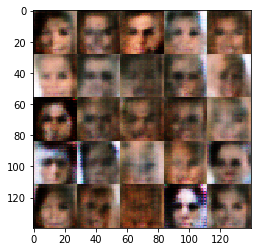

Epoch 1/1... Discriminator Loss: 2.2779... Generator Loss: 0.1648
Epoch 1/1... Discriminator Loss: 1.0683... Generator Loss: 0.8380
Epoch 1/1... Discriminator Loss: 1.4063... Generator Loss: 1.0273
Epoch 1/1... Discriminator Loss: 1.3048... Generator Loss: 0.5318
Epoch 1/1... Discriminator Loss: 2.3174... Generator Loss: 0.2276
Epoch 1/1... Discriminator Loss: 1.1544... Generator Loss: 0.9458
Epoch 1/1... Discriminator Loss: 1.4549... Generator Loss: 0.5257
Epoch 1/1... Discriminator Loss: 0.3795... Generator Loss: 2.1018
Epoch 1/1... Discriminator Loss: 1.5078... Generator Loss: 0.7323
Epoch 1/1... Discriminator Loss: 1.6287... Generator Loss: 1.3123


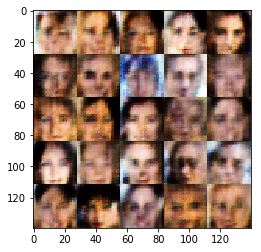

Epoch 1/1... Discriminator Loss: 1.1307... Generator Loss: 0.6060
Epoch 1/1... Discriminator Loss: 1.4176... Generator Loss: 0.4665
Epoch 1/1... Discriminator Loss: 1.7772... Generator Loss: 1.2112
Epoch 1/1... Discriminator Loss: 2.3609... Generator Loss: 0.1441
Epoch 1/1... Discriminator Loss: 1.1687... Generator Loss: 1.2443
Epoch 1/1... Discriminator Loss: 0.9401... Generator Loss: 1.3389
Epoch 1/1... Discriminator Loss: 1.6965... Generator Loss: 2.0277
Epoch 1/1... Discriminator Loss: 1.4287... Generator Loss: 0.5007
Epoch 1/1... Discriminator Loss: 1.3408... Generator Loss: 0.4932
Epoch 1/1... Discriminator Loss: 1.5788... Generator Loss: 0.4632


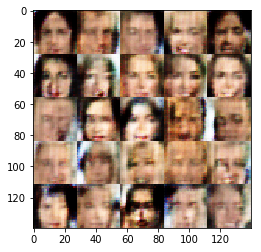

Epoch 1/1... Discriminator Loss: 1.8853... Generator Loss: 0.2769
Epoch 1/1... Discriminator Loss: 1.3359... Generator Loss: 0.6066
Epoch 1/1... Discriminator Loss: 2.2519... Generator Loss: 0.1713
Epoch 1/1... Discriminator Loss: 1.5141... Generator Loss: 0.7499
Epoch 1/1... Discriminator Loss: 1.3925... Generator Loss: 0.6454
Epoch 1/1... Discriminator Loss: 1.4012... Generator Loss: 0.6995
Epoch 1/1... Discriminator Loss: 0.9215... Generator Loss: 0.8963
Epoch 1/1... Discriminator Loss: 1.2273... Generator Loss: 1.4884
Epoch 1/1... Discriminator Loss: 1.0188... Generator Loss: 0.8063
Epoch 1/1... Discriminator Loss: 1.6624... Generator Loss: 0.4491


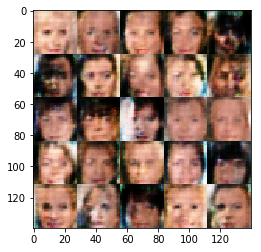

Epoch 1/1... Discriminator Loss: 1.6027... Generator Loss: 0.4135
Epoch 1/1... Discriminator Loss: 1.4136... Generator Loss: 0.6680
Epoch 1/1... Discriminator Loss: 1.3754... Generator Loss: 0.5454
Epoch 1/1... Discriminator Loss: 0.9480... Generator Loss: 0.8812
Epoch 1/1... Discriminator Loss: 1.4137... Generator Loss: 0.3843
Epoch 1/1... Discriminator Loss: 1.5818... Generator Loss: 0.3462
Epoch 1/1... Discriminator Loss: 1.2479... Generator Loss: 0.5202
Epoch 1/1... Discriminator Loss: 1.1729... Generator Loss: 0.5800
Epoch 1/1... Discriminator Loss: 1.6670... Generator Loss: 0.7186
Epoch 1/1... Discriminator Loss: 1.2583... Generator Loss: 1.0397


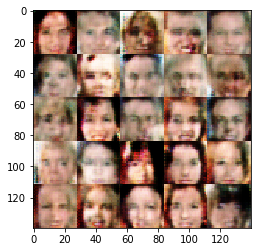

Epoch 1/1... Discriminator Loss: 1.4306... Generator Loss: 0.7183
Epoch 1/1... Discriminator Loss: 1.5042... Generator Loss: 0.9566
Epoch 1/1... Discriminator Loss: 1.2122... Generator Loss: 0.8612
Epoch 1/1... Discriminator Loss: 1.2205... Generator Loss: 1.2294
Epoch 1/1... Discriminator Loss: 1.4583... Generator Loss: 0.5192
Epoch 1/1... Discriminator Loss: 1.2194... Generator Loss: 0.6897
Epoch 1/1... Discriminator Loss: 1.3466... Generator Loss: 0.5687
Epoch 1/1... Discriminator Loss: 1.6271... Generator Loss: 0.3432
Epoch 1/1... Discriminator Loss: 1.6706... Generator Loss: 1.3455
Epoch 1/1... Discriminator Loss: 1.4097... Generator Loss: 0.4629


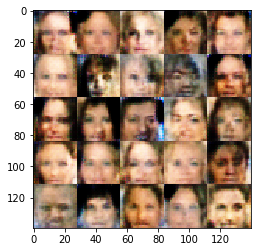

Epoch 1/1... Discriminator Loss: 1.6211... Generator Loss: 0.8072
Epoch 1/1... Discriminator Loss: 1.8753... Generator Loss: 0.2307
Epoch 1/1... Discriminator Loss: 0.9107... Generator Loss: 2.1329
Epoch 1/1... Discriminator Loss: 1.2608... Generator Loss: 0.5377
Epoch 1/1... Discriminator Loss: 1.0185... Generator Loss: 1.6161
Epoch 1/1... Discriminator Loss: 1.6349... Generator Loss: 0.7023
Epoch 1/1... Discriminator Loss: 1.7305... Generator Loss: 0.2662
Epoch 1/1... Discriminator Loss: 0.8947... Generator Loss: 1.7052
Epoch 1/1... Discriminator Loss: 1.5313... Generator Loss: 0.6076
Epoch 1/1... Discriminator Loss: 1.9939... Generator Loss: 0.2741


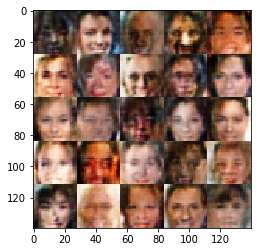

Epoch 1/1... Discriminator Loss: 1.1068... Generator Loss: 0.8773
Epoch 1/1... Discriminator Loss: 1.4654... Generator Loss: 0.5360
Epoch 1/1... Discriminator Loss: 1.6119... Generator Loss: 0.2740
Epoch 1/1... Discriminator Loss: 1.2504... Generator Loss: 0.5681
Epoch 1/1... Discriminator Loss: 1.5808... Generator Loss: 0.3404
Epoch 1/1... Discriminator Loss: 1.5766... Generator Loss: 0.4957
Epoch 1/1... Discriminator Loss: 1.4715... Generator Loss: 0.4803
Epoch 1/1... Discriminator Loss: 1.6418... Generator Loss: 0.3133
Epoch 1/1... Discriminator Loss: 1.3881... Generator Loss: 0.6076
Epoch 1/1... Discriminator Loss: 1.6939... Generator Loss: 0.2734


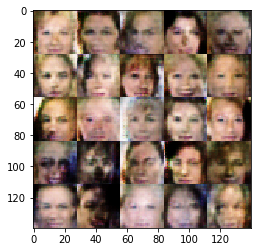

Epoch 1/1... Discriminator Loss: 1.6950... Generator Loss: 0.3456
Epoch 1/1... Discriminator Loss: 2.0023... Generator Loss: 0.2084
Epoch 1/1... Discriminator Loss: 1.3833... Generator Loss: 0.6953
Epoch 1/1... Discriminator Loss: 1.1705... Generator Loss: 0.7121
Epoch 1/1... Discriminator Loss: 1.2538... Generator Loss: 0.5300
Epoch 1/1... Discriminator Loss: 1.4334... Generator Loss: 0.9701
Epoch 1/1... Discriminator Loss: 1.3246... Generator Loss: 0.6829
Epoch 1/1... Discriminator Loss: 1.5465... Generator Loss: 0.4965
Epoch 1/1... Discriminator Loss: 1.4343... Generator Loss: 0.7690
Epoch 1/1... Discriminator Loss: 1.1896... Generator Loss: 0.7354


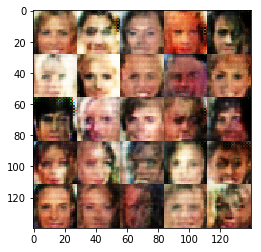

Epoch 1/1... Discriminator Loss: 1.1507... Generator Loss: 0.7463
Epoch 1/1... Discriminator Loss: 1.0113... Generator Loss: 0.7010
Epoch 1/1... Discriminator Loss: 1.5788... Generator Loss: 0.3490
Epoch 1/1... Discriminator Loss: 2.0129... Generator Loss: 0.1920
Epoch 1/1... Discriminator Loss: 1.5781... Generator Loss: 1.0619
Epoch 1/1... Discriminator Loss: 1.5198... Generator Loss: 0.3596
Epoch 1/1... Discriminator Loss: 1.4939... Generator Loss: 0.4657
Epoch 1/1... Discriminator Loss: 1.9655... Generator Loss: 0.2373
Epoch 1/1... Discriminator Loss: 1.2593... Generator Loss: 0.6930
Epoch 1/1... Discriminator Loss: 1.4761... Generator Loss: 0.5808


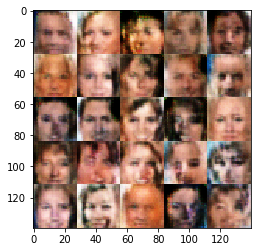

Epoch 1/1... Discriminator Loss: 1.1488... Generator Loss: 0.8594
Epoch 1/1... Discriminator Loss: 1.3164... Generator Loss: 0.4658
Epoch 1/1... Discriminator Loss: 1.5886... Generator Loss: 0.4218
Epoch 1/1... Discriminator Loss: 1.2426... Generator Loss: 0.8275
Epoch 1/1... Discriminator Loss: 1.5613... Generator Loss: 0.3352
Epoch 1/1... Discriminator Loss: 1.5081... Generator Loss: 0.6555
Epoch 1/1... Discriminator Loss: 1.2993... Generator Loss: 0.5898
Epoch 1/1... Discriminator Loss: 0.7813... Generator Loss: 1.4298
Epoch 1/1... Discriminator Loss: 1.2954... Generator Loss: 0.6452
Epoch 1/1... Discriminator Loss: 1.0002... Generator Loss: 0.7665


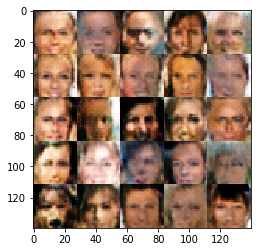

Epoch 1/1... Discriminator Loss: 1.3795... Generator Loss: 0.4387
Epoch 1/1... Discriminator Loss: 1.2703... Generator Loss: 0.7036
Epoch 1/1... Discriminator Loss: 1.3289... Generator Loss: 0.6326
Epoch 1/1... Discriminator Loss: 1.3320... Generator Loss: 0.4249
Epoch 1/1... Discriminator Loss: 1.0300... Generator Loss: 0.6919
Epoch 1/1... Discriminator Loss: 1.5596... Generator Loss: 0.4203
Epoch 1/1... Discriminator Loss: 1.6762... Generator Loss: 0.4142
Epoch 1/1... Discriminator Loss: 1.2906... Generator Loss: 1.3901
Epoch 1/1... Discriminator Loss: 1.1765... Generator Loss: 0.8197
Epoch 1/1... Discriminator Loss: 1.3127... Generator Loss: 0.7054


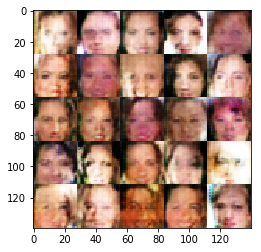

Epoch 1/1... Discriminator Loss: 1.4010... Generator Loss: 0.5264
Epoch 1/1... Discriminator Loss: 1.2216... Generator Loss: 0.7284
Epoch 1/1... Discriminator Loss: 1.3088... Generator Loss: 0.4649
Epoch 1/1... Discriminator Loss: 1.1854... Generator Loss: 0.9020
Epoch 1/1... Discriminator Loss: 1.2940... Generator Loss: 0.7865
Epoch 1/1... Discriminator Loss: 1.6994... Generator Loss: 0.7339
Epoch 1/1... Discriminator Loss: 1.2899... Generator Loss: 0.6956
Epoch 1/1... Discriminator Loss: 1.4813... Generator Loss: 0.4443
Epoch 1/1... Discriminator Loss: 1.2552... Generator Loss: 1.4535
Epoch 1/1... Discriminator Loss: 1.5957... Generator Loss: 0.5257


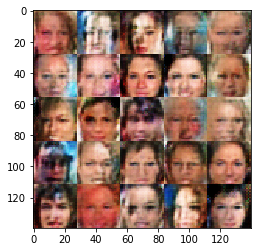

Epoch 1/1... Discriminator Loss: 1.0864... Generator Loss: 0.6423
Epoch 1/1... Discriminator Loss: 1.1411... Generator Loss: 1.2672
Epoch 1/1... Discriminator Loss: 1.6265... Generator Loss: 0.4444
Epoch 1/1... Discriminator Loss: 1.4578... Generator Loss: 0.4429
Epoch 1/1... Discriminator Loss: 1.2941... Generator Loss: 0.5118
Epoch 1/1... Discriminator Loss: 1.3749... Generator Loss: 0.8440
Epoch 1/1... Discriminator Loss: 1.3273... Generator Loss: 0.3974
Epoch 1/1... Discriminator Loss: 1.2770... Generator Loss: 0.4518
Epoch 1/1... Discriminator Loss: 1.5250... Generator Loss: 0.3338
Epoch 1/1... Discriminator Loss: 1.1535... Generator Loss: 0.7042


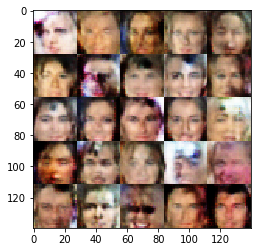

Epoch 1/1... Discriminator Loss: 0.9083... Generator Loss: 0.7946
Epoch 1/1... Discriminator Loss: 1.2196... Generator Loss: 0.4753
Epoch 1/1... Discriminator Loss: 1.4253... Generator Loss: 0.4269
Epoch 1/1... Discriminator Loss: 1.4812... Generator Loss: 0.4898
Epoch 1/1... Discriminator Loss: 1.2776... Generator Loss: 0.5963
Epoch 1/1... Discriminator Loss: 1.3868... Generator Loss: 0.4883
Epoch 1/1... Discriminator Loss: 1.5347... Generator Loss: 0.4149
Epoch 1/1... Discriminator Loss: 0.8741... Generator Loss: 1.6940
Epoch 1/1... Discriminator Loss: 1.0548... Generator Loss: 0.6273
Epoch 1/1... Discriminator Loss: 1.0536... Generator Loss: 0.6615


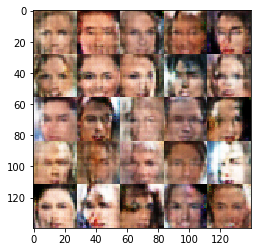

Epoch 1/1... Discriminator Loss: 1.0311... Generator Loss: 0.8976
Epoch 1/1... Discriminator Loss: 1.6018... Generator Loss: 0.3342
Epoch 1/1... Discriminator Loss: 1.9431... Generator Loss: 0.2491
Epoch 1/1... Discriminator Loss: 1.0618... Generator Loss: 0.8596
Epoch 1/1... Discriminator Loss: 1.3608... Generator Loss: 1.1259
Epoch 1/1... Discriminator Loss: 1.7803... Generator Loss: 0.2767
Epoch 1/1... Discriminator Loss: 1.4830... Generator Loss: 0.3456
Epoch 1/1... Discriminator Loss: 1.4614... Generator Loss: 0.9771
Epoch 1/1... Discriminator Loss: 1.2079... Generator Loss: 0.8410
Epoch 1/1... Discriminator Loss: 1.0066... Generator Loss: 0.6817


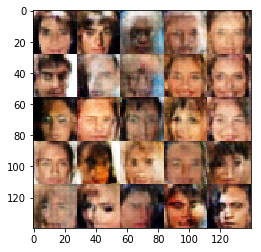

Epoch 1/1... Discriminator Loss: 1.4426... Generator Loss: 1.0931
Epoch 1/1... Discriminator Loss: 1.2915... Generator Loss: 1.1302
Epoch 1/1... Discriminator Loss: 0.7490... Generator Loss: 1.3894
Epoch 1/1... Discriminator Loss: 1.0063... Generator Loss: 1.0428
Epoch 1/1... Discriminator Loss: 1.2662... Generator Loss: 0.5420
Epoch 1/1... Discriminator Loss: 1.5841... Generator Loss: 0.3798
Epoch 1/1... Discriminator Loss: 0.7051... Generator Loss: 0.9595
Epoch 1/1... Discriminator Loss: 1.7344... Generator Loss: 0.3822
Epoch 1/1... Discriminator Loss: 1.0366... Generator Loss: 0.6890
Epoch 1/1... Discriminator Loss: 1.2610... Generator Loss: 1.4616


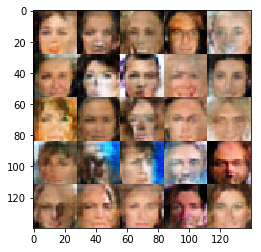

Epoch 1/1... Discriminator Loss: 1.2572... Generator Loss: 0.6421
Epoch 1/1... Discriminator Loss: 1.3305... Generator Loss: 1.0949
Epoch 1/1... Discriminator Loss: 1.2358... Generator Loss: 0.5781
Epoch 1/1... Discriminator Loss: 1.2504... Generator Loss: 0.9154
Epoch 1/1... Discriminator Loss: 1.2003... Generator Loss: 0.5985
Epoch 1/1... Discriminator Loss: 0.9171... Generator Loss: 0.7996
Epoch 1/1... Discriminator Loss: 1.2662... Generator Loss: 0.5347
Epoch 1/1... Discriminator Loss: 1.9325... Generator Loss: 0.2055
Epoch 1/1... Discriminator Loss: 0.8705... Generator Loss: 0.7046
Epoch 1/1... Discriminator Loss: 1.4304... Generator Loss: 0.7467


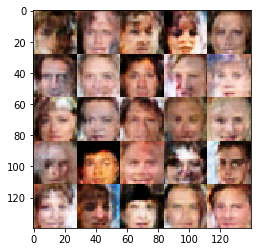

Epoch 1/1... Discriminator Loss: 1.2128... Generator Loss: 0.4776
Epoch 1/1... Discriminator Loss: 1.6170... Generator Loss: 0.3186
Epoch 1/1... Discriminator Loss: 1.5697... Generator Loss: 0.3157
Epoch 1/1... Discriminator Loss: 2.9365... Generator Loss: 2.4751
Epoch 1/1... Discriminator Loss: 1.5437... Generator Loss: 0.6087
Epoch 1/1... Discriminator Loss: 1.4992... Generator Loss: 0.4247
Epoch 1/1... Discriminator Loss: 1.2902... Generator Loss: 1.0821
Epoch 1/1... Discriminator Loss: 1.0296... Generator Loss: 0.5353
Epoch 1/1... Discriminator Loss: 1.6903... Generator Loss: 0.2910
Epoch 1/1... Discriminator Loss: 1.3093... Generator Loss: 0.4565


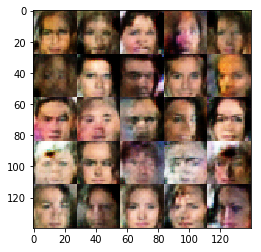

Epoch 1/1... Discriminator Loss: 0.9746... Generator Loss: 0.9506
Epoch 1/1... Discriminator Loss: 0.9440... Generator Loss: 0.9622
Epoch 1/1... Discriminator Loss: 1.0119... Generator Loss: 0.5810
Epoch 1/1... Discriminator Loss: 1.0446... Generator Loss: 1.0413
Epoch 1/1... Discriminator Loss: 1.1864... Generator Loss: 0.6176
Epoch 1/1... Discriminator Loss: 1.3979... Generator Loss: 1.7089
Epoch 1/1... Discriminator Loss: 1.3399... Generator Loss: 0.5494
Epoch 1/1... Discriminator Loss: 1.1742... Generator Loss: 0.7707
Epoch 1/1... Discriminator Loss: 1.5734... Generator Loss: 0.2708
Epoch 1/1... Discriminator Loss: 1.6073... Generator Loss: 0.5522


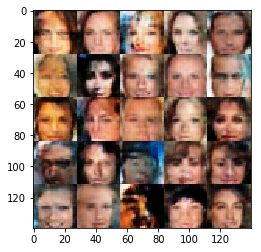

Epoch 1/1... Discriminator Loss: 1.7319... Generator Loss: 0.2832
Epoch 1/1... Discriminator Loss: 0.9468... Generator Loss: 0.7803
Epoch 1/1... Discriminator Loss: 1.0829... Generator Loss: 0.7415
Epoch 1/1... Discriminator Loss: 1.1930... Generator Loss: 0.9344
Epoch 1/1... Discriminator Loss: 0.9914... Generator Loss: 0.5927
Epoch 1/1... Discriminator Loss: 1.0234... Generator Loss: 0.8625
Epoch 1/1... Discriminator Loss: 1.6722... Generator Loss: 0.2638
Epoch 1/1... Discriminator Loss: 0.8681... Generator Loss: 0.9099
Epoch 1/1... Discriminator Loss: 1.8760... Generator Loss: 0.2627
Epoch 1/1... Discriminator Loss: 1.4956... Generator Loss: 0.3294


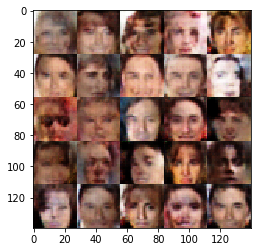

Epoch 1/1... Discriminator Loss: 1.9493... Generator Loss: 0.1931
Epoch 1/1... Discriminator Loss: 1.3840... Generator Loss: 1.9091
Epoch 1/1... Discriminator Loss: 1.2720... Generator Loss: 0.5156
Epoch 1/1... Discriminator Loss: 1.2383... Generator Loss: 0.4804
Epoch 1/1... Discriminator Loss: 1.3703... Generator Loss: 0.5155
Epoch 1/1... Discriminator Loss: 1.5422... Generator Loss: 0.3595
Epoch 1/1... Discriminator Loss: 1.2293... Generator Loss: 0.7574
Epoch 1/1... Discriminator Loss: 0.9925... Generator Loss: 0.8092
Epoch 1/1... Discriminator Loss: 1.5499... Generator Loss: 0.4175
Epoch 1/1... Discriminator Loss: 1.5479... Generator Loss: 0.4922


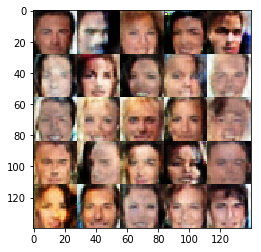

Epoch 1/1... Discriminator Loss: 1.3061... Generator Loss: 0.6566
Epoch 1/1... Discriminator Loss: 1.1977... Generator Loss: 0.5903
Epoch 1/1... Discriminator Loss: 0.8796... Generator Loss: 0.7965
Epoch 1/1... Discriminator Loss: 1.4730... Generator Loss: 0.3823
Epoch 1/1... Discriminator Loss: 1.2645... Generator Loss: 0.8248
Epoch 1/1... Discriminator Loss: 1.1340... Generator Loss: 0.8591
Epoch 1/1... Discriminator Loss: 1.4239... Generator Loss: 0.4681
Epoch 1/1... Discriminator Loss: 1.3321... Generator Loss: 0.5291
Epoch 1/1... Discriminator Loss: 1.1031... Generator Loss: 0.7858
Epoch 1/1... Discriminator Loss: 1.1433... Generator Loss: 0.6048


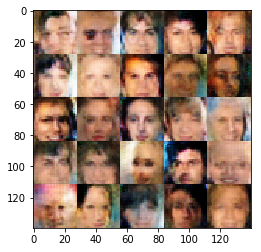

Epoch 1/1... Discriminator Loss: 1.3138... Generator Loss: 0.4833
Epoch 1/1... Discriminator Loss: 1.3939... Generator Loss: 0.4637
Epoch 1/1... Discriminator Loss: 1.8380... Generator Loss: 0.2784
Epoch 1/1... Discriminator Loss: 1.2921... Generator Loss: 0.5037
Epoch 1/1... Discriminator Loss: 1.1172... Generator Loss: 1.1794
Epoch 1/1... Discriminator Loss: 1.2268... Generator Loss: 0.6777
Epoch 1/1... Discriminator Loss: 1.4895... Generator Loss: 0.3427
Epoch 1/1... Discriminator Loss: 2.3797... Generator Loss: 0.1149
Epoch 1/1... Discriminator Loss: 1.3880... Generator Loss: 0.3988
Epoch 1/1... Discriminator Loss: 0.8097... Generator Loss: 1.0725


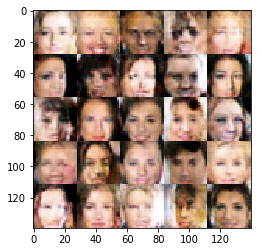

Epoch 1/1... Discriminator Loss: 0.9052... Generator Loss: 1.1296
Epoch 1/1... Discriminator Loss: 1.4945... Generator Loss: 0.3542
Epoch 1/1... Discriminator Loss: 1.1307... Generator Loss: 0.6439
Epoch 1/1... Discriminator Loss: 0.9042... Generator Loss: 1.9337
Epoch 1/1... Discriminator Loss: 0.7888... Generator Loss: 1.3582
Epoch 1/1... Discriminator Loss: 1.0826... Generator Loss: 1.4031
Epoch 1/1... Discriminator Loss: 1.3099... Generator Loss: 0.9130
Epoch 1/1... Discriminator Loss: 0.7804... Generator Loss: 1.5740
Epoch 1/1... Discriminator Loss: 0.7852... Generator Loss: 0.9123
Epoch 1/1... Discriminator Loss: 1.3339... Generator Loss: 1.0794


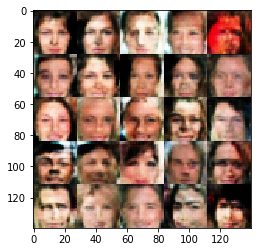

Epoch 1/1... Discriminator Loss: 0.9196... Generator Loss: 1.1668
Epoch 1/1... Discriminator Loss: 2.3147... Generator Loss: 3.2089
Epoch 1/1... Discriminator Loss: 1.4147... Generator Loss: 2.0151
Epoch 1/1... Discriminator Loss: 1.3333... Generator Loss: 0.4716
Epoch 1/1... Discriminator Loss: 0.7530... Generator Loss: 1.9501
Epoch 1/1... Discriminator Loss: 2.9012... Generator Loss: 0.0752
Epoch 1/1... Discriminator Loss: 1.7625... Generator Loss: 0.3126
Epoch 1/1... Discriminator Loss: 1.4659... Generator Loss: 0.4667
Epoch 1/1... Discriminator Loss: 1.2258... Generator Loss: 0.4717
Epoch 1/1... Discriminator Loss: 1.4736... Generator Loss: 1.4374


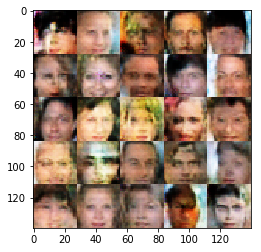

Epoch 1/1... Discriminator Loss: 1.1056... Generator Loss: 0.5505
Epoch 1/1... Discriminator Loss: 1.4148... Generator Loss: 0.3902
Epoch 1/1... Discriminator Loss: 1.2053... Generator Loss: 0.5346
Epoch 1/1... Discriminator Loss: 1.6534... Generator Loss: 0.3137
Epoch 1/1... Discriminator Loss: 0.3880... Generator Loss: 1.6686
Epoch 1/1... Discriminator Loss: 0.4495... Generator Loss: 1.4371
Epoch 1/1... Discriminator Loss: 1.6825... Generator Loss: 0.2604
Epoch 1/1... Discriminator Loss: 1.8056... Generator Loss: 0.2704
Epoch 1/1... Discriminator Loss: 1.2273... Generator Loss: 0.4586
Epoch 1/1... Discriminator Loss: 2.6178... Generator Loss: 0.0909


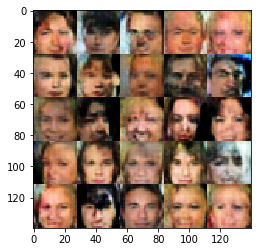

Epoch 1/1... Discriminator Loss: 1.1884... Generator Loss: 0.7433
Epoch 1/1... Discriminator Loss: 1.4452... Generator Loss: 0.4243
Epoch 1/1... Discriminator Loss: 0.9682... Generator Loss: 0.8341
Epoch 1/1... Discriminator Loss: 1.5573... Generator Loss: 0.3035
Epoch 1/1... Discriminator Loss: 1.0254... Generator Loss: 0.7931
Epoch 1/1... Discriminator Loss: 1.6564... Generator Loss: 0.8623
Epoch 1/1... Discriminator Loss: 0.8934... Generator Loss: 0.7449
Epoch 1/1... Discriminator Loss: 0.9922... Generator Loss: 0.6613
Epoch 1/1... Discriminator Loss: 0.8754... Generator Loss: 0.8088
Epoch 1/1... Discriminator Loss: 0.9823... Generator Loss: 0.7466


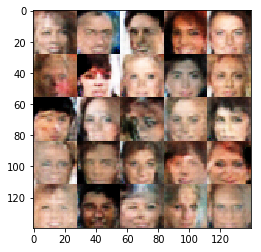

Epoch 1/1... Discriminator Loss: 1.1693... Generator Loss: 0.4288
Epoch 1/1... Discriminator Loss: 1.0769... Generator Loss: 0.6027
Epoch 1/1... Discriminator Loss: 0.6189... Generator Loss: 1.1050
Epoch 1/1... Discriminator Loss: 1.2583... Generator Loss: 1.3421
Epoch 1/1... Discriminator Loss: 0.8262... Generator Loss: 0.8449
Epoch 1/1... Discriminator Loss: 0.9608... Generator Loss: 0.7537
Epoch 1/1... Discriminator Loss: 0.4592... Generator Loss: 2.4827
Epoch 1/1... Discriminator Loss: 0.2131... Generator Loss: 2.5932
Epoch 1/1... Discriminator Loss: 1.0547... Generator Loss: 0.5929
Epoch 1/1... Discriminator Loss: 1.3301... Generator Loss: 0.4500


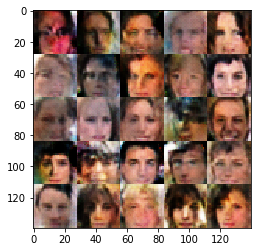

Epoch 1/1... Discriminator Loss: 1.0784... Generator Loss: 0.6603
Epoch 1/1... Discriminator Loss: 0.7932... Generator Loss: 1.5850
Epoch 1/1... Discriminator Loss: 1.6738... Generator Loss: 0.3141
Epoch 1/1... Discriminator Loss: 1.2926... Generator Loss: 0.6589
Epoch 1/1... Discriminator Loss: 1.1919... Generator Loss: 0.5767
Epoch 1/1... Discriminator Loss: 1.1758... Generator Loss: 0.5393
Epoch 1/1... Discriminator Loss: 1.3220... Generator Loss: 0.4620
Epoch 1/1... Discriminator Loss: 1.1575... Generator Loss: 0.5219
Epoch 1/1... Discriminator Loss: 1.1046... Generator Loss: 0.5711
Epoch 1/1... Discriminator Loss: 0.9922... Generator Loss: 1.9703


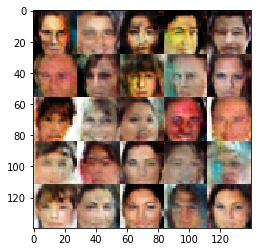

Epoch 1/1... Discriminator Loss: 1.1674... Generator Loss: 0.8482
Epoch 1/1... Discriminator Loss: 0.6654... Generator Loss: 1.0700
Epoch 1/1... Discriminator Loss: 1.1447... Generator Loss: 0.4749
Epoch 1/1... Discriminator Loss: 1.3923... Generator Loss: 0.4104
Epoch 1/1... Discriminator Loss: 1.1048... Generator Loss: 1.4694
Epoch 1/1... Discriminator Loss: 1.2324... Generator Loss: 1.6267
Epoch 1/1... Discriminator Loss: 0.9899... Generator Loss: 0.7933
Epoch 1/1... Discriminator Loss: 0.9311... Generator Loss: 0.7098
Epoch 1/1... Discriminator Loss: 0.8824... Generator Loss: 0.9272
Epoch 1/1... Discriminator Loss: 1.3607... Generator Loss: 2.4387


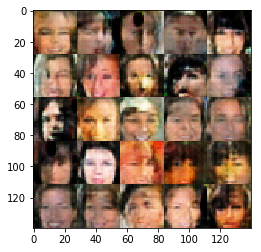

Epoch 1/1... Discriminator Loss: 1.4190... Generator Loss: 0.3953
Epoch 1/1... Discriminator Loss: 1.2473... Generator Loss: 0.4417
Epoch 1/1... Discriminator Loss: 1.4428... Generator Loss: 0.5192
Epoch 1/1... Discriminator Loss: 0.8029... Generator Loss: 1.3672
Epoch 1/1... Discriminator Loss: 1.5549... Generator Loss: 0.3824
Epoch 1/1... Discriminator Loss: 0.9686... Generator Loss: 1.4669
Epoch 1/1... Discriminator Loss: 1.1924... Generator Loss: 0.4911
Epoch 1/1... Discriminator Loss: 1.1776... Generator Loss: 0.6915
Epoch 1/1... Discriminator Loss: 0.9541... Generator Loss: 0.6781
Epoch 1/1... Discriminator Loss: 0.9374... Generator Loss: 0.6211


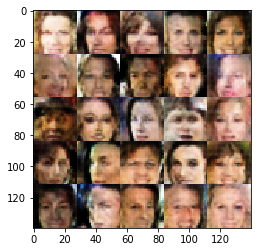

Epoch 1/1... Discriminator Loss: 0.7627... Generator Loss: 1.1936
Epoch 1/1... Discriminator Loss: 0.9311... Generator Loss: 1.4985
Epoch 1/1... Discriminator Loss: 1.6116... Generator Loss: 0.3286
Epoch 1/1... Discriminator Loss: 2.0243... Generator Loss: 0.1743
Epoch 1/1... Discriminator Loss: 0.3319... Generator Loss: 1.6583
Epoch 1/1... Discriminator Loss: 1.0594... Generator Loss: 0.6692
Epoch 1/1... Discriminator Loss: 2.9912... Generator Loss: 0.0703
Epoch 1/1... Discriminator Loss: 1.0236... Generator Loss: 0.5665
Epoch 1/1... Discriminator Loss: 1.3356... Generator Loss: 0.8955
Epoch 1/1... Discriminator Loss: 1.0527... Generator Loss: 0.6094


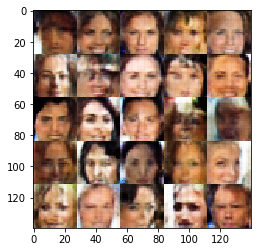

Epoch 1/1... Discriminator Loss: 0.8592... Generator Loss: 0.9544
Epoch 1/1... Discriminator Loss: 1.2824... Generator Loss: 0.6693
Epoch 1/1... Discriminator Loss: 1.7277... Generator Loss: 0.2360
Epoch 1/1... Discriminator Loss: 1.1298... Generator Loss: 0.6163
Epoch 1/1... Discriminator Loss: 1.7795... Generator Loss: 0.3617
Epoch 1/1... Discriminator Loss: 1.1834... Generator Loss: 1.7575
Epoch 1/1... Discriminator Loss: 1.0805... Generator Loss: 0.8542
Epoch 1/1... Discriminator Loss: 1.2729... Generator Loss: 0.4633
Epoch 1/1... Discriminator Loss: 0.9461... Generator Loss: 0.9333
Epoch 1/1... Discriminator Loss: 1.2232... Generator Loss: 0.4882


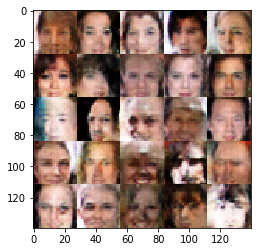

Epoch 1/1... Discriminator Loss: 0.8136... Generator Loss: 0.9985
Epoch 1/1... Discriminator Loss: 0.7302... Generator Loss: 1.0240
Epoch 1/1... Discriminator Loss: 1.4423... Generator Loss: 0.4469
Epoch 1/1... Discriminator Loss: 0.8228... Generator Loss: 1.1367
Epoch 1/1... Discriminator Loss: 0.8196... Generator Loss: 0.8137
Epoch 1/1... Discriminator Loss: 1.9893... Generator Loss: 0.2095
Epoch 1/1... Discriminator Loss: 0.6367... Generator Loss: 1.7638
Epoch 1/1... Discriminator Loss: 1.0705... Generator Loss: 0.6029
Epoch 1/1... Discriminator Loss: 1.9834... Generator Loss: 1.5518
Epoch 1/1... Discriminator Loss: 1.1558... Generator Loss: 1.9417


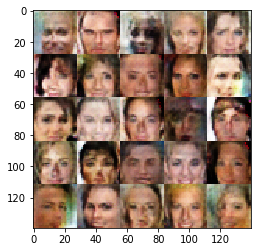

Epoch 1/1... Discriminator Loss: 1.4417... Generator Loss: 1.3178
Epoch 1/1... Discriminator Loss: 1.5829... Generator Loss: 0.3235
Epoch 1/1... Discriminator Loss: 0.8860... Generator Loss: 1.4065
Epoch 1/1... Discriminator Loss: 1.0870... Generator Loss: 0.5606
Epoch 1/1... Discriminator Loss: 2.2168... Generator Loss: 0.1598
Epoch 1/1... Discriminator Loss: 1.7824... Generator Loss: 0.2949
Epoch 1/1... Discriminator Loss: 0.8241... Generator Loss: 1.3254
Epoch 1/1... Discriminator Loss: 0.7871... Generator Loss: 0.8311
Epoch 1/1... Discriminator Loss: 0.3226... Generator Loss: 1.9011
Epoch 1/1... Discriminator Loss: 1.6449... Generator Loss: 0.3028


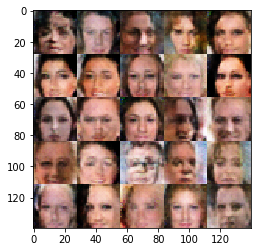

Epoch 1/1... Discriminator Loss: 1.4347... Generator Loss: 1.9840
Epoch 1/1... Discriminator Loss: 0.6263... Generator Loss: 1.7839
Epoch 1/1... Discriminator Loss: 1.2783... Generator Loss: 1.0198
Epoch 1/1... Discriminator Loss: 1.2256... Generator Loss: 0.5105
Epoch 1/1... Discriminator Loss: 1.3785... Generator Loss: 0.7864
Epoch 1/1... Discriminator Loss: 0.9107... Generator Loss: 0.8685
Epoch 1/1... Discriminator Loss: 0.9462... Generator Loss: 0.9296
Epoch 1/1... Discriminator Loss: 0.7874... Generator Loss: 1.4712
Epoch 1/1... Discriminator Loss: 1.0626... Generator Loss: 2.1601
Epoch 1/1... Discriminator Loss: 1.0283... Generator Loss: 0.9842


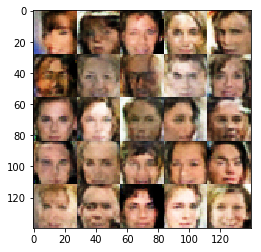

Epoch 1/1... Discriminator Loss: 0.8999... Generator Loss: 0.8057
Epoch 1/1... Discriminator Loss: 0.9208... Generator Loss: 1.0870
Epoch 1/1... Discriminator Loss: 2.0805... Generator Loss: 0.1864
Epoch 1/1... Discriminator Loss: 1.1988... Generator Loss: 0.7845
Epoch 1/1... Discriminator Loss: 1.4301... Generator Loss: 0.3798
Epoch 1/1... Discriminator Loss: 1.2709... Generator Loss: 0.4514
Epoch 1/1... Discriminator Loss: 1.2785... Generator Loss: 0.5169
Epoch 1/1... Discriminator Loss: 0.8344... Generator Loss: 1.0000
Epoch 1/1... Discriminator Loss: 1.3596... Generator Loss: 0.4952
Epoch 1/1... Discriminator Loss: 1.0383... Generator Loss: 0.8399


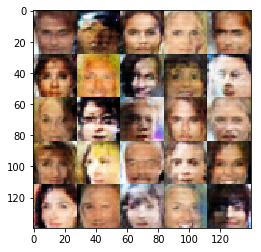

Epoch 1/1... Discriminator Loss: 1.1550... Generator Loss: 0.7926
Epoch 1/1... Discriminator Loss: 1.1230... Generator Loss: 0.6213
Epoch 1/1... Discriminator Loss: 0.6105... Generator Loss: 1.0458
Epoch 1/1... Discriminator Loss: 0.9399... Generator Loss: 0.7256
Epoch 1/1... Discriminator Loss: 0.8964... Generator Loss: 0.9274
Epoch 1/1... Discriminator Loss: 0.6275... Generator Loss: 1.0123
Epoch 1/1... Discriminator Loss: 0.8191... Generator Loss: 1.0245
Epoch 1/1... Discriminator Loss: 0.9184... Generator Loss: 1.0931
Epoch 1/1... Discriminator Loss: 1.0280... Generator Loss: 0.6382
Epoch 1/1... Discriminator Loss: 0.9742... Generator Loss: 0.9808


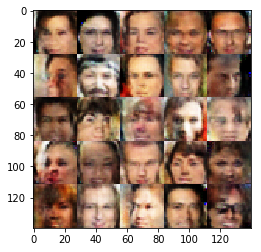

Epoch 1/1... Discriminator Loss: 1.0495... Generator Loss: 1.3216
Epoch 1/1... Discriminator Loss: 0.9581... Generator Loss: 0.6839
Epoch 1/1... Discriminator Loss: 1.4978... Generator Loss: 0.3225
Epoch 1/1... Discriminator Loss: 1.6234... Generator Loss: 0.3143
Epoch 1/1... Discriminator Loss: 0.9080... Generator Loss: 0.6910
Epoch 1/1... Discriminator Loss: 1.4688... Generator Loss: 0.3935
Epoch 1/1... Discriminator Loss: 0.8867... Generator Loss: 1.0075
Epoch 1/1... Discriminator Loss: 1.1752... Generator Loss: 0.5546
Epoch 1/1... Discriminator Loss: 0.6830... Generator Loss: 1.2413
Epoch 1/1... Discriminator Loss: 1.6487... Generator Loss: 0.3407


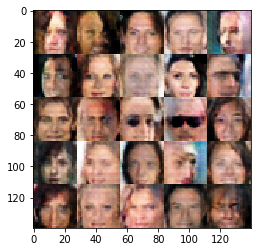

Epoch 1/1... Discriminator Loss: 1.0143... Generator Loss: 0.8827
Epoch 1/1... Discriminator Loss: 0.8783... Generator Loss: 1.0102
Epoch 1/1... Discriminator Loss: 1.5724... Generator Loss: 0.3070
Epoch 1/1... Discriminator Loss: 0.4309... Generator Loss: 1.6783
Epoch 1/1... Discriminator Loss: 0.9568... Generator Loss: 1.2606
Epoch 1/1... Discriminator Loss: 1.1756... Generator Loss: 0.6575
Epoch 1/1... Discriminator Loss: 1.0265... Generator Loss: 0.9686
Epoch 1/1... Discriminator Loss: 1.2767... Generator Loss: 0.6036
Epoch 1/1... Discriminator Loss: 1.0587... Generator Loss: 1.3174
Epoch 1/1... Discriminator Loss: 0.7318... Generator Loss: 1.5790


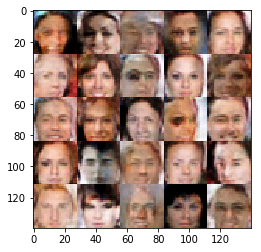

Epoch 1/1... Discriminator Loss: 0.8653... Generator Loss: 1.2355
Epoch 1/1... Discriminator Loss: 1.3216... Generator Loss: 0.5852
Epoch 1/1... Discriminator Loss: 1.7577... Generator Loss: 0.2526
Epoch 1/1... Discriminator Loss: 0.8417... Generator Loss: 1.0465
Epoch 1/1... Discriminator Loss: 1.7860... Generator Loss: 0.3018
Epoch 1/1... Discriminator Loss: 1.1394... Generator Loss: 1.2720
Epoch 1/1... Discriminator Loss: 1.1153... Generator Loss: 0.6285
Epoch 1/1... Discriminator Loss: 1.3191... Generator Loss: 0.4365
Epoch 1/1... Discriminator Loss: 0.6871... Generator Loss: 1.0588
Epoch 1/1... Discriminator Loss: 0.7574... Generator Loss: 1.2778


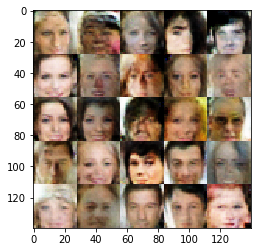

Epoch 1/1... Discriminator Loss: 1.1064... Generator Loss: 0.7141
Epoch 1/1... Discriminator Loss: 0.9749... Generator Loss: 1.4935
Epoch 1/1... Discriminator Loss: 1.7649... Generator Loss: 0.2609
Epoch 1/1... Discriminator Loss: 0.8045... Generator Loss: 0.9853
Epoch 1/1... Discriminator Loss: 1.1187... Generator Loss: 0.5839
Epoch 1/1... Discriminator Loss: 2.1838... Generator Loss: 0.1580
Epoch 1/1... Discriminator Loss: 1.5292... Generator Loss: 0.3979
Epoch 1/1... Discriminator Loss: 1.1552... Generator Loss: 0.7154
Epoch 1/1... Discriminator Loss: 1.6153... Generator Loss: 0.8730
Epoch 1/1... Discriminator Loss: 1.3762... Generator Loss: 0.4954


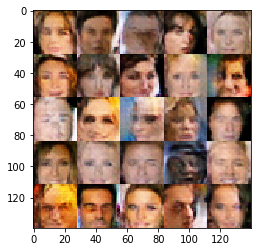

Epoch 1/1... Discriminator Loss: 1.4716... Generator Loss: 0.8867
Epoch 1/1... Discriminator Loss: 0.8266... Generator Loss: 0.9956
Epoch 1/1... Discriminator Loss: 1.1663... Generator Loss: 0.5171
Epoch 1/1... Discriminator Loss: 0.9480... Generator Loss: 0.7597
Epoch 1/1... Discriminator Loss: 1.1286... Generator Loss: 0.6382
Epoch 1/1... Discriminator Loss: 0.6667... Generator Loss: 1.0977
Epoch 1/1... Discriminator Loss: 1.1226... Generator Loss: 0.5224
Epoch 1/1... Discriminator Loss: 1.4683... Generator Loss: 0.3438
Epoch 1/1... Discriminator Loss: 1.0319... Generator Loss: 0.5979
Epoch 1/1... Discriminator Loss: 1.3234... Generator Loss: 0.7142


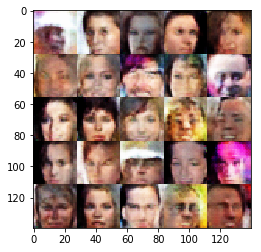

Epoch 1/1... Discriminator Loss: 1.1466... Generator Loss: 0.6758
Epoch 1/1... Discriminator Loss: 1.0981... Generator Loss: 0.6607
Epoch 1/1... Discriminator Loss: 0.9271... Generator Loss: 0.7244
Epoch 1/1... Discriminator Loss: 1.2325... Generator Loss: 0.4702
Epoch 1/1... Discriminator Loss: 2.2898... Generator Loss: 0.1371
Epoch 1/1... Discriminator Loss: 1.0375... Generator Loss: 0.5812
Epoch 1/1... Discriminator Loss: 1.0171... Generator Loss: 1.1924
Epoch 1/1... Discriminator Loss: 1.2608... Generator Loss: 0.5010
Epoch 1/1... Discriminator Loss: 1.5197... Generator Loss: 0.3611
Epoch 1/1... Discriminator Loss: 1.2401... Generator Loss: 0.4924


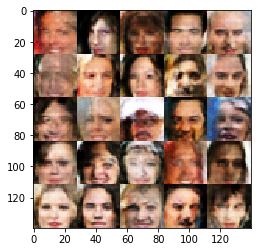

Epoch 1/1... Discriminator Loss: 0.9818... Generator Loss: 0.7599
Epoch 1/1... Discriminator Loss: 0.9984... Generator Loss: 0.8418
Epoch 1/1... Discriminator Loss: 1.1894... Generator Loss: 0.5907
Epoch 1/1... Discriminator Loss: 1.1025... Generator Loss: 0.5903
Epoch 1/1... Discriminator Loss: 1.5662... Generator Loss: 0.3391
Epoch 1/1... Discriminator Loss: 1.5975... Generator Loss: 0.3445
Epoch 1/1... Discriminator Loss: 0.9427... Generator Loss: 0.7977
Epoch 1/1... Discriminator Loss: 1.6585... Generator Loss: 0.2869
Epoch 1/1... Discriminator Loss: 0.6848... Generator Loss: 1.0658
Epoch 1/1... Discriminator Loss: 1.8760... Generator Loss: 0.2434


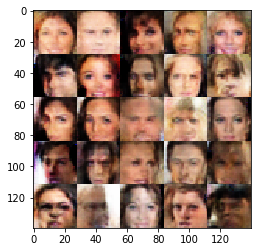

Epoch 1/1... Discriminator Loss: 1.7757... Generator Loss: 0.2633
Epoch 1/1... Discriminator Loss: 1.2209... Generator Loss: 0.4803
Epoch 1/1... Discriminator Loss: 1.7444... Generator Loss: 0.2913
Epoch 1/1... Discriminator Loss: 1.2078... Generator Loss: 0.4848
Epoch 1/1... Discriminator Loss: 1.4667... Generator Loss: 0.3643
Epoch 1/1... Discriminator Loss: 0.8743... Generator Loss: 1.2859
Epoch 1/1... Discriminator Loss: 1.6146... Generator Loss: 0.3368
Epoch 1/1... Discriminator Loss: 1.1762... Generator Loss: 0.9675
Epoch 1/1... Discriminator Loss: 0.9265... Generator Loss: 0.7497
Epoch 1/1... Discriminator Loss: 0.9474... Generator Loss: 1.2647


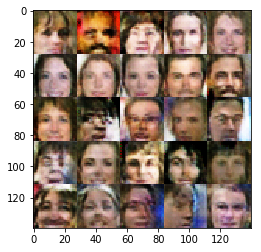

Epoch 1/1... Discriminator Loss: 1.4290... Generator Loss: 0.4079
Epoch 1/1... Discriminator Loss: 0.7426... Generator Loss: 0.8819
Epoch 1/1... Discriminator Loss: 0.7937... Generator Loss: 0.8109
Epoch 1/1... Discriminator Loss: 1.1142... Generator Loss: 0.5709
Epoch 1/1... Discriminator Loss: 0.9163... Generator Loss: 0.7709
Epoch 1/1... Discriminator Loss: 1.1301... Generator Loss: 0.8552
Epoch 1/1... Discriminator Loss: 1.1853... Generator Loss: 0.6281
Epoch 1/1... Discriminator Loss: 0.9311... Generator Loss: 0.9217
Epoch 1/1... Discriminator Loss: 1.4414... Generator Loss: 0.3944
Epoch 1/1... Discriminator Loss: 2.5125... Generator Loss: 0.1021


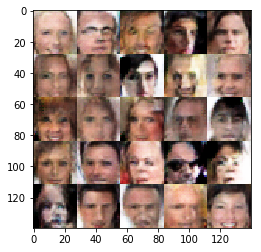

Epoch 1/1... Discriminator Loss: 1.1844... Generator Loss: 0.6572
Epoch 1/1... Discriminator Loss: 1.6290... Generator Loss: 0.3268
Epoch 1/1... Discriminator Loss: 0.9830... Generator Loss: 0.7541
Epoch 1/1... Discriminator Loss: 1.0498... Generator Loss: 1.2146
Epoch 1/1... Discriminator Loss: 1.0966... Generator Loss: 0.7023
Epoch 1/1... Discriminator Loss: 0.6531... Generator Loss: 1.4029
Epoch 1/1... Discriminator Loss: 1.2522... Generator Loss: 0.6968
Epoch 1/1... Discriminator Loss: 1.8525... Generator Loss: 0.2373
Epoch 1/1... Discriminator Loss: 0.9817... Generator Loss: 0.6958
Epoch 1/1... Discriminator Loss: 1.2482... Generator Loss: 0.7528


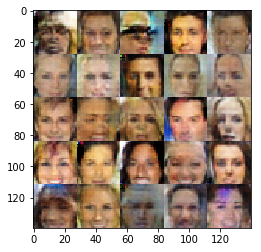

Epoch 1/1... Discriminator Loss: 1.4412... Generator Loss: 0.4050
Epoch 1/1... Discriminator Loss: 1.2483... Generator Loss: 0.5791
Epoch 1/1... Discriminator Loss: 1.6251... Generator Loss: 0.3657
Epoch 1/1... Discriminator Loss: 1.4414... Generator Loss: 0.4336
Epoch 1/1... Discriminator Loss: 1.1215... Generator Loss: 0.5446
Epoch 1/1... Discriminator Loss: 0.7742... Generator Loss: 0.9031
Epoch 1/1... Discriminator Loss: 1.1324... Generator Loss: 0.5407
Epoch 1/1... Discriminator Loss: 0.6877... Generator Loss: 1.9131
Epoch 1/1... Discriminator Loss: 1.3882... Generator Loss: 0.4698
Epoch 1/1... Discriminator Loss: 0.4667... Generator Loss: 1.3706


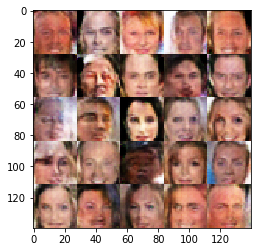

Epoch 1/1... Discriminator Loss: 1.0988... Generator Loss: 0.5447
Epoch 1/1... Discriminator Loss: 0.8047... Generator Loss: 1.0178
Epoch 1/1... Discriminator Loss: 1.3322... Generator Loss: 0.4691
Epoch 1/1... Discriminator Loss: 2.0513... Generator Loss: 0.2105
Epoch 1/1... Discriminator Loss: 1.5787... Generator Loss: 0.3612
Epoch 1/1... Discriminator Loss: 0.8874... Generator Loss: 1.9045
Epoch 1/1... Discriminator Loss: 1.2549... Generator Loss: 1.1570
Epoch 1/1... Discriminator Loss: 0.7083... Generator Loss: 1.1427
Epoch 1/1... Discriminator Loss: 2.1761... Generator Loss: 0.1500
Epoch 1/1... Discriminator Loss: 1.3055... Generator Loss: 0.4844


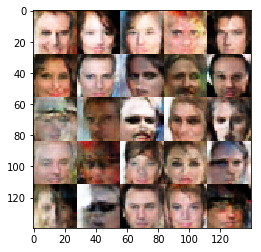

Epoch 1/1... Discriminator Loss: 1.9702... Generator Loss: 0.2342
Epoch 1/1... Discriminator Loss: 1.2125... Generator Loss: 0.5672
Epoch 1/1... Discriminator Loss: 2.2008... Generator Loss: 0.1410
Epoch 1/1... Discriminator Loss: 1.1600... Generator Loss: 2.0168
Epoch 1/1... Discriminator Loss: 1.0822... Generator Loss: 0.7355
Epoch 1/1... Discriminator Loss: 1.0730... Generator Loss: 0.9118
Epoch 1/1... Discriminator Loss: 1.8615... Generator Loss: 0.2175
Epoch 1/1... Discriminator Loss: 1.1039... Generator Loss: 0.5291
Epoch 1/1... Discriminator Loss: 1.3971... Generator Loss: 0.4058
Epoch 1/1... Discriminator Loss: 1.1493... Generator Loss: 0.6544


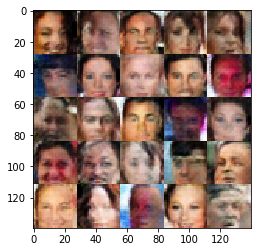

Epoch 1/1... Discriminator Loss: 1.4733... Generator Loss: 0.3520
Epoch 1/1... Discriminator Loss: 1.1244... Generator Loss: 1.0840
Epoch 1/1... Discriminator Loss: 1.3979... Generator Loss: 0.3581
Epoch 1/1... Discriminator Loss: 1.0173... Generator Loss: 0.6650
Epoch 1/1... Discriminator Loss: 1.4927... Generator Loss: 0.3611
Epoch 1/1... Discriminator Loss: 1.2135... Generator Loss: 0.6664
Epoch 1/1... Discriminator Loss: 1.2715... Generator Loss: 0.4919
Epoch 1/1... Discriminator Loss: 1.2852... Generator Loss: 1.6958
Epoch 1/1... Discriminator Loss: 1.5604... Generator Loss: 0.2976
Epoch 1/1... Discriminator Loss: 1.9035... Generator Loss: 0.2692


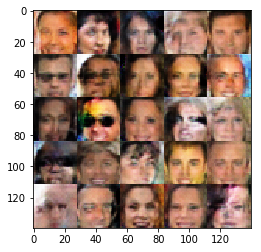

Epoch 1/1... Discriminator Loss: 1.3725... Generator Loss: 0.3976
Epoch 1/1... Discriminator Loss: 1.5546... Generator Loss: 0.3191
Epoch 1/1... Discriminator Loss: 0.4605... Generator Loss: 1.4273
Epoch 1/1... Discriminator Loss: 1.4452... Generator Loss: 0.4266
Epoch 1/1... Discriminator Loss: 1.2855... Generator Loss: 0.4708
Epoch 1/1... Discriminator Loss: 1.1626... Generator Loss: 0.5940
Epoch 1/1... Discriminator Loss: 1.0202... Generator Loss: 0.6822
Epoch 1/1... Discriminator Loss: 1.6391... Generator Loss: 0.3172
Epoch 1/1... Discriminator Loss: 1.0680... Generator Loss: 0.9819
Epoch 1/1... Discriminator Loss: 1.2272... Generator Loss: 0.5587


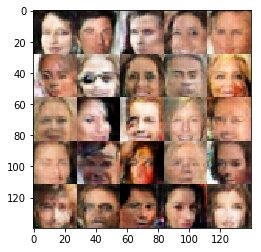

Epoch 1/1... Discriminator Loss: 1.2855... Generator Loss: 0.4417
Epoch 1/1... Discriminator Loss: 0.9832... Generator Loss: 0.9270
Epoch 1/1... Discriminator Loss: 1.1259... Generator Loss: 0.5643
Epoch 1/1... Discriminator Loss: 0.8132... Generator Loss: 1.5252
Epoch 1/1... Discriminator Loss: 0.6286... Generator Loss: 1.0515
Epoch 1/1... Discriminator Loss: 0.7338... Generator Loss: 0.9395
Epoch 1/1... Discriminator Loss: 1.3951... Generator Loss: 0.3986
Epoch 1/1... Discriminator Loss: 0.8477... Generator Loss: 0.8646
Epoch 1/1... Discriminator Loss: 1.6959... Generator Loss: 0.2565
Epoch 1/1... Discriminator Loss: 1.4344... Generator Loss: 0.4059


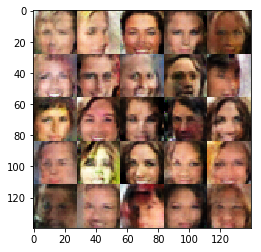

Epoch 1/1... Discriminator Loss: 1.0850... Generator Loss: 0.5944
Epoch 1/1... Discriminator Loss: 0.8888... Generator Loss: 0.8756
Epoch 1/1... Discriminator Loss: 0.8553... Generator Loss: 1.5442
Epoch 1/1... Discriminator Loss: 0.9200... Generator Loss: 0.7205
Epoch 1/1... Discriminator Loss: 1.1593... Generator Loss: 0.6118
Epoch 1/1... Discriminator Loss: 1.3876... Generator Loss: 0.4331
Epoch 1/1... Discriminator Loss: 1.7425... Generator Loss: 0.2525
Epoch 1/1... Discriminator Loss: 1.4603... Generator Loss: 0.4864
Epoch 1/1... Discriminator Loss: 1.5663... Generator Loss: 2.8518
Epoch 1/1... Discriminator Loss: 1.1549... Generator Loss: 0.5389


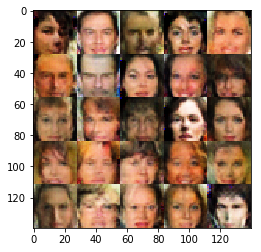

Epoch 1/1... Discriminator Loss: 1.4327... Generator Loss: 0.3965
Epoch 1/1... Discriminator Loss: 1.1290... Generator Loss: 0.5528
Epoch 1/1... Discriminator Loss: 0.7992... Generator Loss: 1.0258
Epoch 1/1... Discriminator Loss: 2.2085... Generator Loss: 0.1651
Epoch 1/1... Discriminator Loss: 1.2403... Generator Loss: 0.6701
Epoch 1/1... Discriminator Loss: 0.7127... Generator Loss: 0.8666
Epoch 1/1... Discriminator Loss: 0.9901... Generator Loss: 0.5837
Epoch 1/1... Discriminator Loss: 1.4085... Generator Loss: 0.4418
Epoch 1/1... Discriminator Loss: 1.3047... Generator Loss: 0.7146
Epoch 1/1... Discriminator Loss: 1.7461... Generator Loss: 0.2971


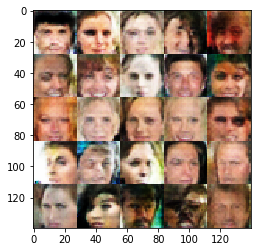

Epoch 1/1... Discriminator Loss: 1.3602... Generator Loss: 0.5526
Epoch 1/1... Discriminator Loss: 1.8211... Generator Loss: 0.2333
Epoch 1/1... Discriminator Loss: 1.4081... Generator Loss: 0.4362
Epoch 1/1... Discriminator Loss: 2.0446... Generator Loss: 0.1861
Epoch 1/1... Discriminator Loss: 1.2786... Generator Loss: 0.4842
Epoch 1/1... Discriminator Loss: 1.3482... Generator Loss: 0.4177
Epoch 1/1... Discriminator Loss: 1.3674... Generator Loss: 0.5393
Epoch 1/1... Discriminator Loss: 1.2700... Generator Loss: 0.6319
Epoch 1/1... Discriminator Loss: 1.2311... Generator Loss: 0.5424
Epoch 1/1... Discriminator Loss: 0.3990... Generator Loss: 1.3843


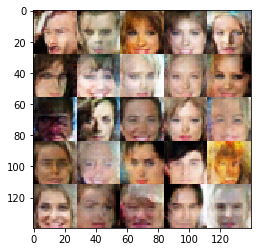

Epoch 1/1... Discriminator Loss: 1.1408... Generator Loss: 0.7334
Epoch 1/1... Discriminator Loss: 1.6364... Generator Loss: 0.2977
Epoch 1/1... Discriminator Loss: 1.8738... Generator Loss: 0.2719
Epoch 1/1... Discriminator Loss: 1.2054... Generator Loss: 0.5956
Epoch 1/1... Discriminator Loss: 0.5699... Generator Loss: 1.1327
Epoch 1/1... Discriminator Loss: 1.7947... Generator Loss: 0.3120
Epoch 1/1... Discriminator Loss: 1.1150... Generator Loss: 1.0798
Epoch 1/1... Discriminator Loss: 0.9207... Generator Loss: 0.9240
Epoch 1/1... Discriminator Loss: 0.9284... Generator Loss: 0.7898
Epoch 1/1... Discriminator Loss: 0.6899... Generator Loss: 1.0979


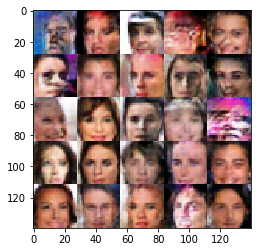

Epoch 1/1... Discriminator Loss: 1.1854... Generator Loss: 1.6100
Epoch 1/1... Discriminator Loss: 0.7494... Generator Loss: 0.8062
Epoch 1/1... Discriminator Loss: 1.6217... Generator Loss: 1.7917
Epoch 1/1... Discriminator Loss: 1.1452... Generator Loss: 0.8177
Epoch 1/1... Discriminator Loss: 0.9020... Generator Loss: 0.7739
Epoch 1/1... Discriminator Loss: 1.5410... Generator Loss: 0.3913
Epoch 1/1... Discriminator Loss: 1.5634... Generator Loss: 0.4984
Epoch 1/1... Discriminator Loss: 1.3966... Generator Loss: 0.4295
Epoch 1/1... Discriminator Loss: 1.8067... Generator Loss: 0.2629
Epoch 1/1... Discriminator Loss: 0.9494... Generator Loss: 1.1012


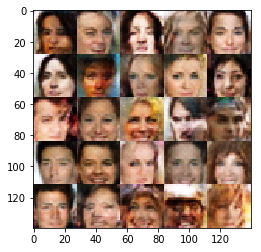

Epoch 1/1... Discriminator Loss: 1.0204... Generator Loss: 0.6054
Epoch 1/1... Discriminator Loss: 1.2015... Generator Loss: 0.6289
Epoch 1/1... Discriminator Loss: 1.1412... Generator Loss: 1.0399
Epoch 1/1... Discriminator Loss: 0.5744... Generator Loss: 2.0461
Epoch 1/1... Discriminator Loss: 1.2534... Generator Loss: 0.5778
Epoch 1/1... Discriminator Loss: 1.4141... Generator Loss: 0.3748
Epoch 1/1... Discriminator Loss: 0.9436... Generator Loss: 1.1393
Epoch 1/1... Discriminator Loss: 0.9350... Generator Loss: 0.7520
Epoch 1/1... Discriminator Loss: 0.8466... Generator Loss: 0.9302
Epoch 1/1... Discriminator Loss: 1.0353... Generator Loss: 0.6236


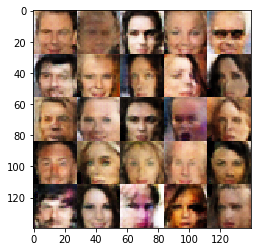

Epoch 1/1... Discriminator Loss: 0.9342... Generator Loss: 1.0850
Epoch 1/1... Discriminator Loss: 1.2558... Generator Loss: 0.6871
Epoch 1/1... Discriminator Loss: 0.9060... Generator Loss: 0.8051


In [49]:
batch_size = 32
z_dim = 100
learning_rate = 0.0005
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.